<font size="3">Importing Required Libraries

In this section, we import the necessary libraries for data handling, visualization, preprocessing, and building the deep learning model.</font>

In [ ]:
import zipfile
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential , load_model , save_model
from tensorflow.keras.layers import Dense , Flatten , Dropout , Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam 

<font size="3">Loading and Exploring the Dataset

We load the dataset and check its structure. This helps us understand what kind of data we are working with.</font>

In [ ]:
# extracting the zip file
with zipfile.ZipFile('MRI.zip' , 'r') as file:
    file.extractall('.')

In [ ]:
# load data and preprocess
images = []
Mask = []
path = "lgg-mri-segmentation/kaggle_3m"
for folder in sorted(os.listdir(path)):
    folder_path = os.path.join(path, folder)
    if not os.path.isdir(folder_path):
        continue
    # if os.path.isdir(folder_path):
    image_path , mask_path = None, None

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if "mask" in file.lower():
            mask_path = file_path
        else:
            image_path = file_path
    if image_path and mask_path:
        img = cv2.imread(image_path)
        msk = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)
        if img is None or msk is None:
            print(f"error to {folder}")
            continue
            
        img = cv2.resize(img , (256,256))
        msk = cv2.resize(msk , (256,256))

        img = img.astype(np.float32) / 255.0
        msk = (msk > 127).astype(np.uint8)

        images.append(img)
        Mask.append(msk)


In [ ]:
# mask type
type(Mask)

list

In [ ]:
# image type
type(images)

list

In [ ]:
# convert image and mask to numpy array
images = np.array(images)
Mask = np.array(Mask)

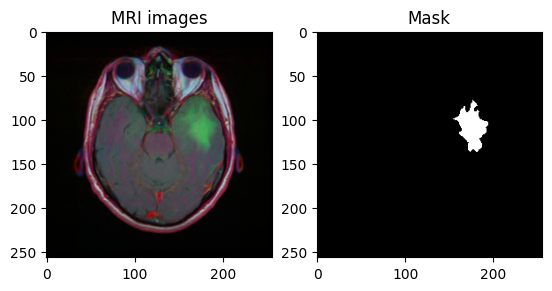

In [ ]:
# show sample image and mask
plt.subplot(1,2,1)
plt.imshow(images[100])
plt.title("MRI images")
plt.subplot(1,2,2)
plt.imshow(Mask[100] , cmap='gray')
plt.title("Mask")
plt.show()


In [ ]:
images.shape

(111, 256, 256, 3)

In [10]:
Mask.shape

(111, 256, 256)

In [ ]:
# expand_dims is used to add an extra dimension to the array.
Mask = np.expand_dims(Mask, axis=-1)
Mask.shape

(111, 256, 256, 1)

In [13]:
type(images)

numpy.ndarray

In [14]:
type(Mask)

numpy.ndarray

<font size = 3>Final Mask Model</font>

In [ ]:
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# compile model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy' ])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# fitting the model
history = model.fit(images, Mask, epochs=10, batch_size=5, validation_split=0.2)

Epoch 1/10
18/18 [==============================] - 15s 762ms/step - loss: 0.3896 - accuracy: 0.9637 - val_loss: 0.7340 - val_accuracy: 0.9908
Epoch 2/10
18/18 [==============================] - 14s 753ms/step - loss: 0.0443 - accuracy: 0.9959 - val_loss: 0.0691 - val_accuracy: 0.9908
Epoch 3/10
18/18 [==============================] - 14s 758ms/step - loss: 0.0313 - accuracy: 0.9959 - val_loss: 0.0397 - val_accuracy: 0.9908
Epoch 4/10
18/18 [==============================] - 14s 754ms/step - loss: 0.0214 - accuracy: 0.9959 - val_loss: 0.0416 - val_accuracy: 0.9908
Epoch 5/10
18/18 [==============================] - 14s 764ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.0414 - val_accuracy: 0.9908
Epoch 6/10
18/18 [==============================] - 14s 754ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0664 - val_accuracy: 0.9908
Epoch 7/10
18/18 [==============================] - 13s 751ms/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 0.0303 - val_accuracy: 0.9908

<font size="3">train loss and validation loss</font>

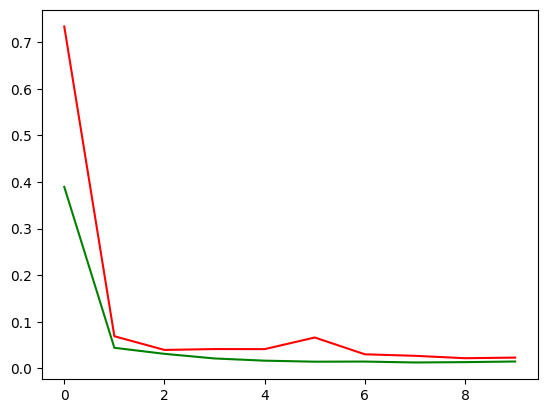

In [21]:
plt.plot(history.history['loss'] , c='green')
plt.plot(history.history['val_loss'] , c='red')

<font size="3">train accuracy and validation accuracy</font>

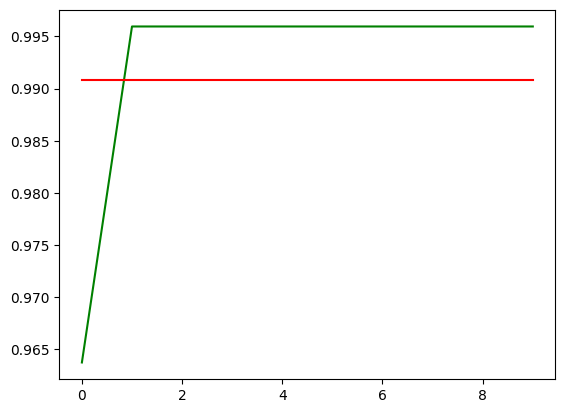

In [22]:
plt.plot(history.history['accuracy'] , c='green')
plt.plot(history.history['val_accuracy'] , c='red')

In [ ]:
# save model
model.save("Mri_Asegmentation.h5")

c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load model for prediction
model_prediction = load_model("Mri_asegmentation.h5")

1/1 [==============================] - 0s 47ms/step


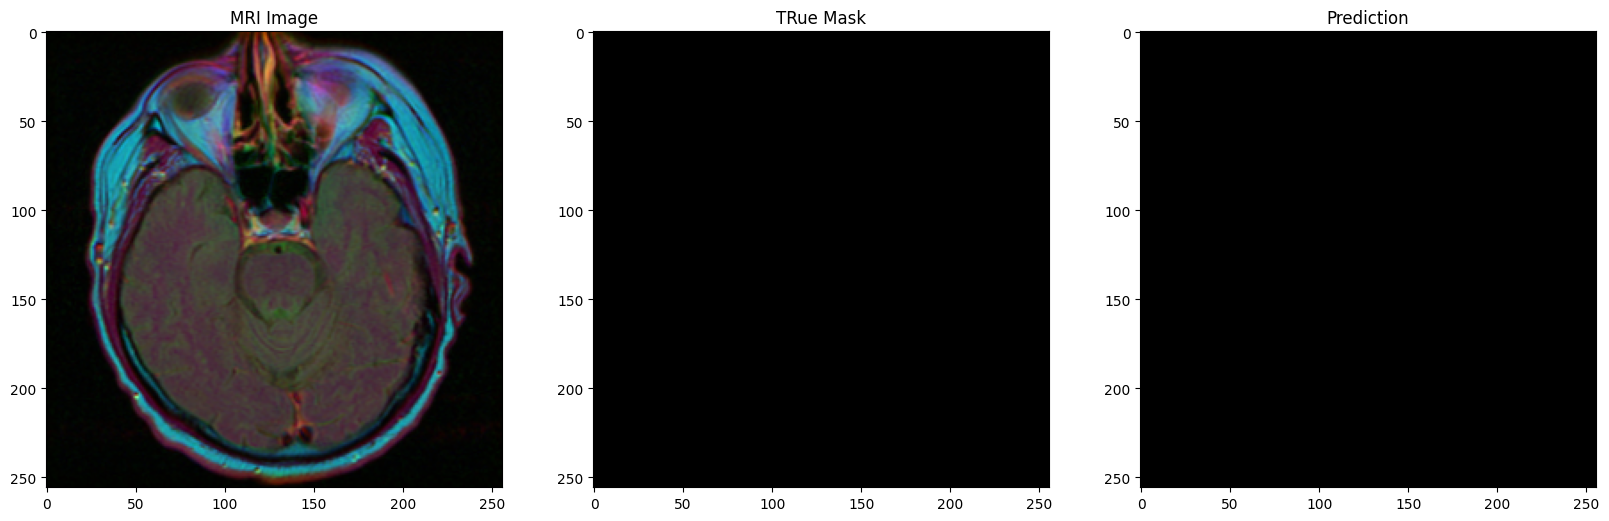

1/1 [==============================] - 0s 49ms/step


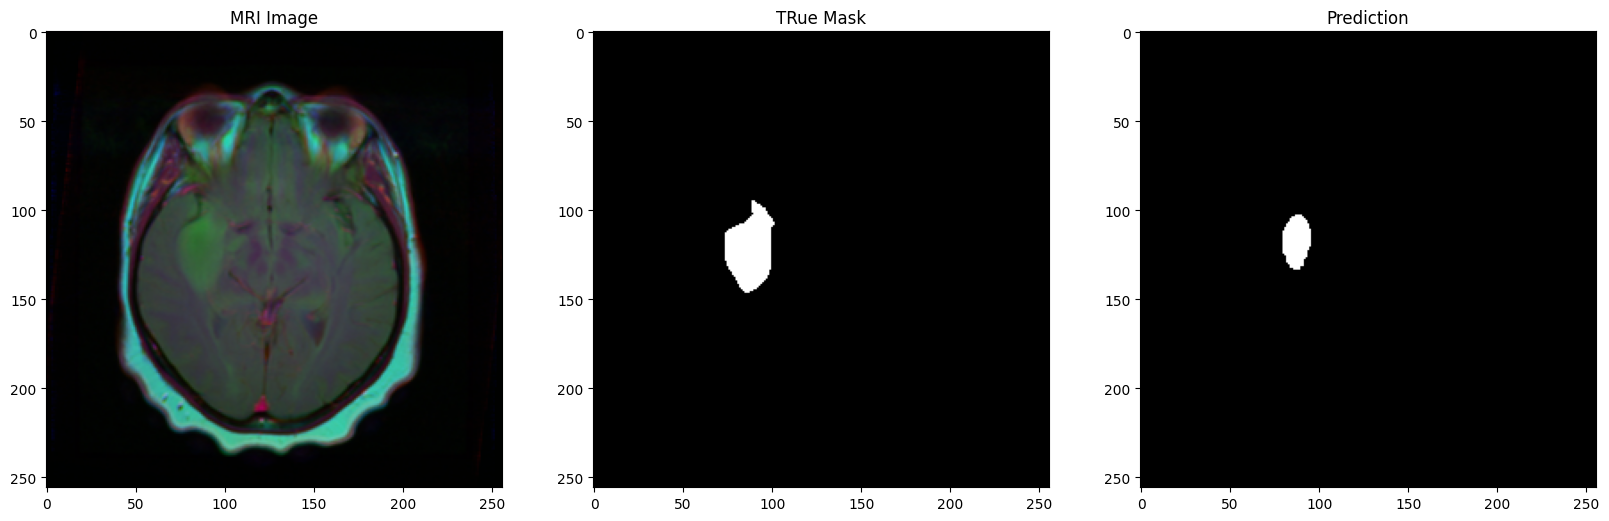

1/1 [==============================] - 0s 54ms/step


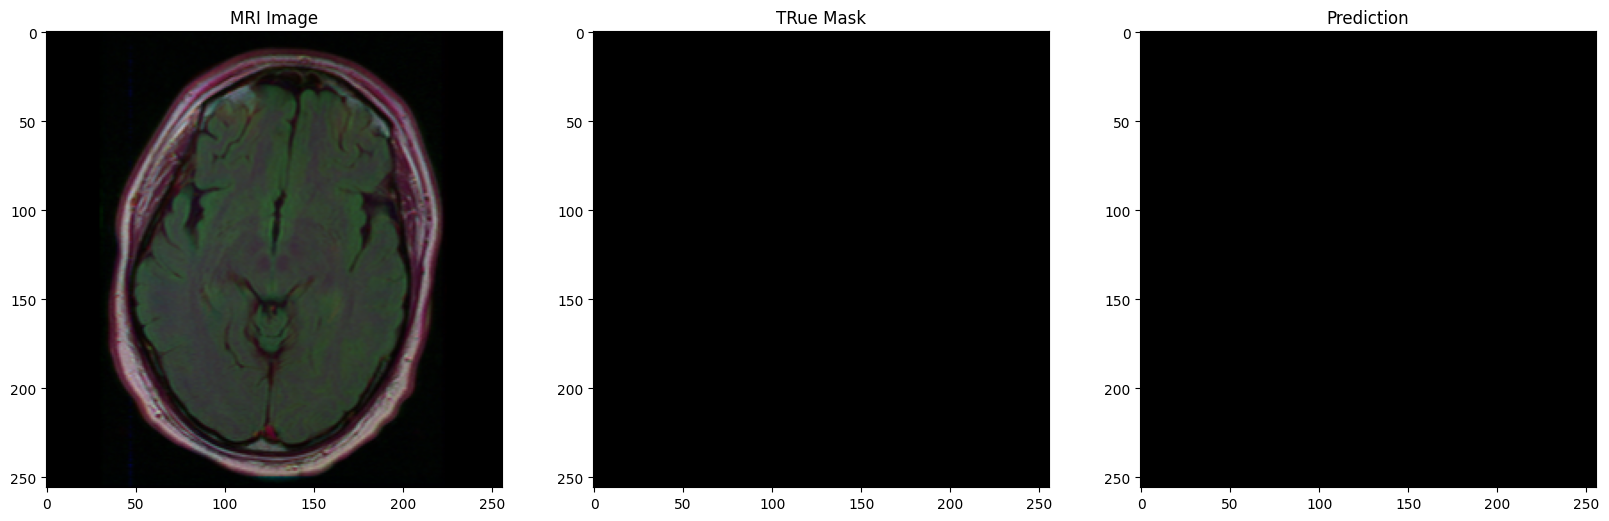

1/1 [==============================] - 0s 54ms/step


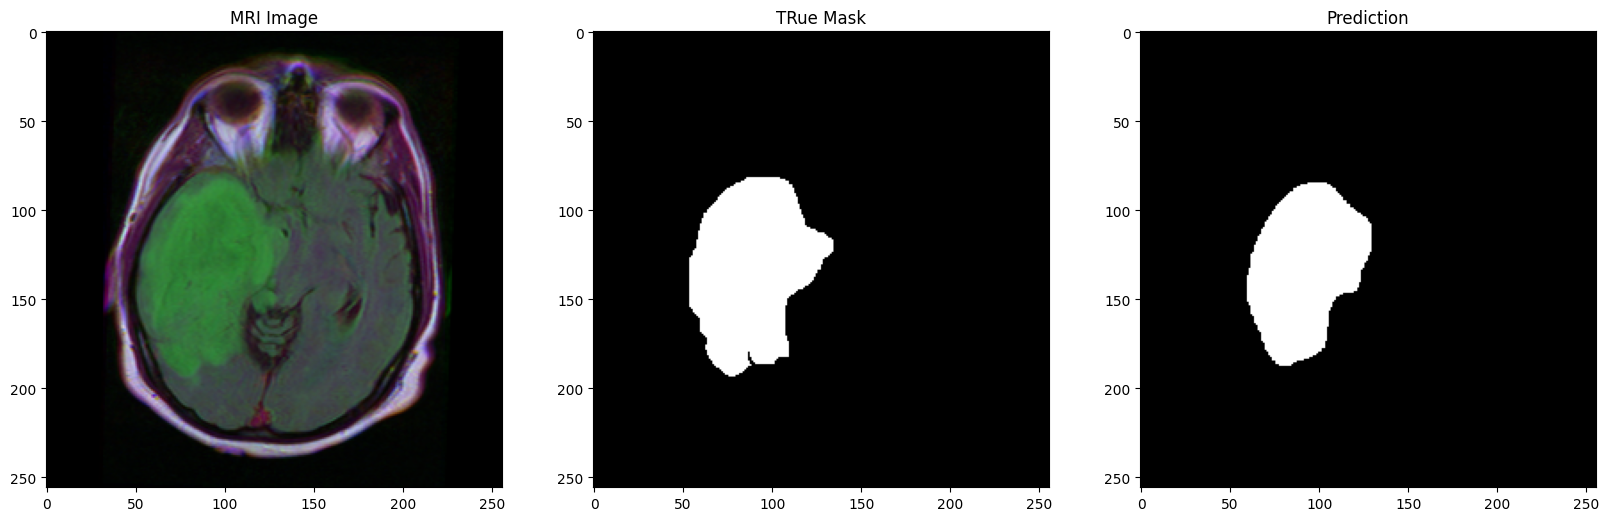

1/1 [==============================] - 0s 66ms/step


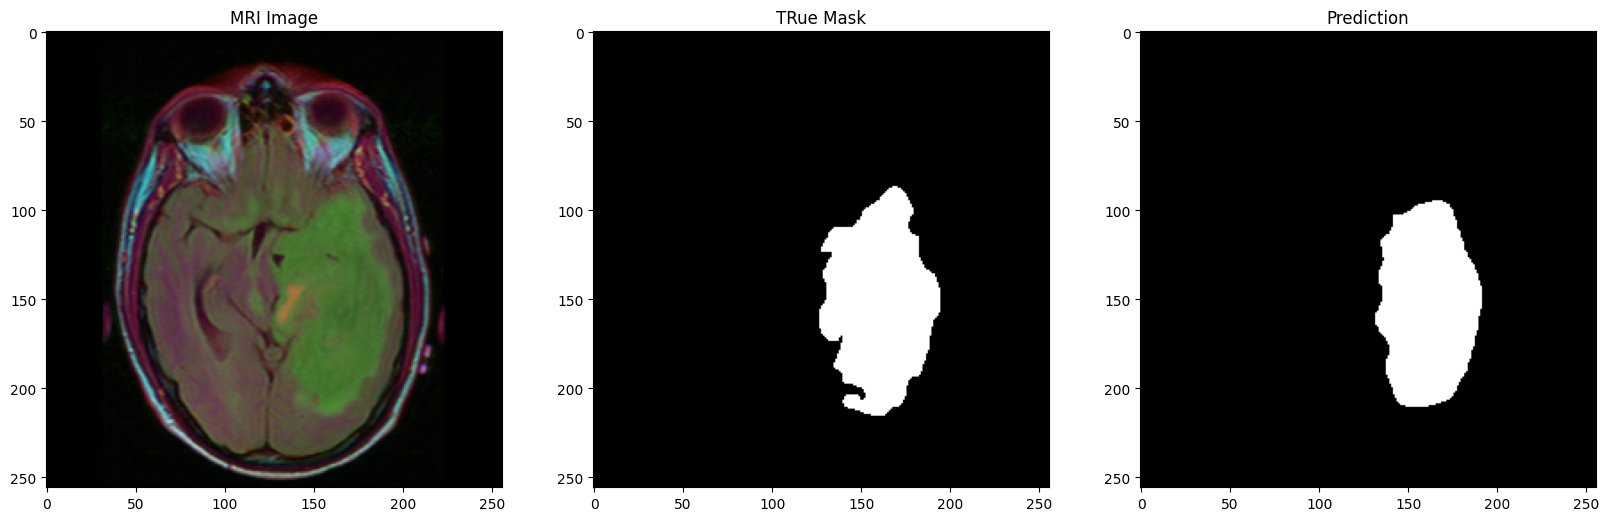

In [ ]:
# prediction
for i in range(0,5):
    pred = model_prediction.predict(np.expand_dims(images[i] , axis=0))[0,:,:,0]
    pred_binary = (pred > 0.2).astype(np.uint8)
    plt.figure(figsize=(20,12))
    plt.subplot(1,3,1)
    plt.title('MRI Image')
    plt.imshow(images[i] , cmap='gray')

    plt.subplot(1,3,2)
    plt.title('TRue Mask')
    plt.imshow(Mask[i] , cmap='gray')

    plt.subplot(1,3,3)
    plt.title('Prediction')
    plt.imshow(pred_binary , cmap='gray')
    plt.show()

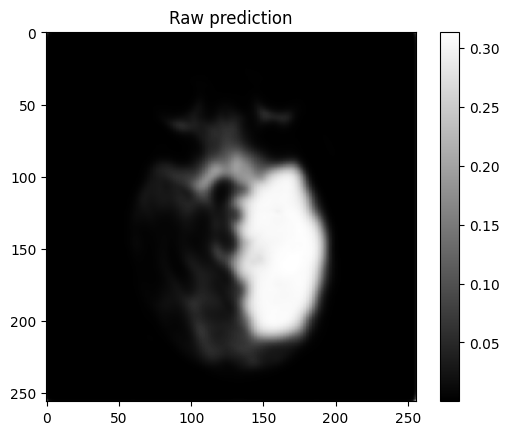

In [53]:
plt.imshow(pred , cmap='gray')
plt.title('Raw prediction')
plt.colorbar()
plt.show()

()
1/1 [==============================] - 0s 45ms/step


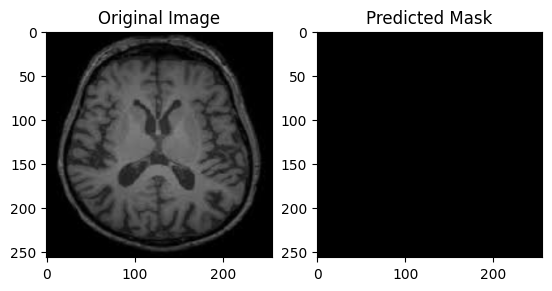

In [51]:
mri = "9 no.jpg"
img = cv2.imread(mri)
img = cv2.resize(img ,(256,256))
img = img.astype("float32")/255.0
img = np.expand_dims(img, axis=0)
print(np.shape(mri))
pred = model_prediction.predict(img)
pred_binary = (pred > 0.2)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(pred_binary[0] , cmap="gray")
plt.title("Predicted Mask")
plt.show()

()
1/1 [==============================] - 0s 52ms/step


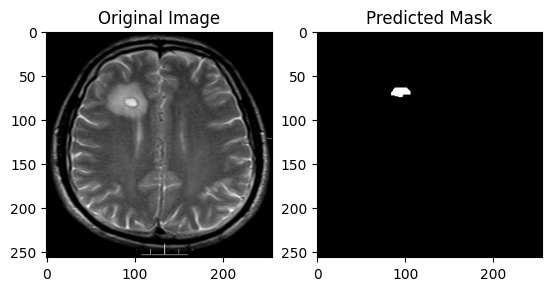

In [47]:
mri = "Y3.jpg"
img = cv2.imread(mri)
img = cv2.resize(img ,(256,256))
img = img.astype("float32")/255.0
img = np.expand_dims(img, axis=0)
print(np.shape(mri))
pred = model_prediction.predict(img)
pred_binary = (pred > 0.08).astype(np.uint8)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(pred_binary[0] , cmap="gray")
plt.title("Predicted Mask")
plt.show()